# Step 1: Import packages


In [1]:
!pip install --upgrade tensorflow
!pip install tensorflow-model-optimization

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
     |████████████████████████████████| 215kB 15.1MB/s 


In [2]:
import os
import glob
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from numpy import array
from numpy import hstack
#from keras.callbacks import EarlyStopping
#from keras.optimizers import RMSprop
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import sample
import tempfile
import tensorflow_model_optimization as tfmot
import math

In [3]:
print(tf.__version__) 
tf.test.gpu_device_name()

2.5.0


''

# Step 2: Mount Google drive

In [11]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)
os.listdir()

Mounted at /content/drive


['old',
 'Training',
 'TFLiteModels',
 'Training_polished',
 'Classifier.png',
 'Predictor.png',
 'PNN.png',
 'KerasModels',
 'Testing',
 'SafeDriver.ipynb']

# Step 3: Data preprocessing

## a. Basic data features

In [4]:
n_features = 6 # ax, ay, az, jx, jy, jz
n_class = 6    # idle, cruise, start, stop, left, right
n_steps = 20   # customize

## b. Read CSV files from drive

In [5]:
train_path = '/content/drive/My Drive/Colab Notebooks/Training_polished/'
test_path = '/content/drive/My Drive/Colab Notebooks/Testing/'

In [18]:
def read_file(file_path, file_name, n_class):
  '''
  This function reads a CSV file, generate a dataset that contains 3-axis acceleration and jerk,
  and classification of motions in one-hot format.
  '''
  # Load CSV file
  print(file_name)
  read_data = pd.read_csv(file_path + file_name)  
  # read all features in Dataframe
  ax = read_data['ax'].to_numpy()
  ay = read_data['ay'].to_numpy()
  az = read_data['az'].to_numpy()

  jx = np.absolute(read_data['jx'].to_numpy())
  jy = np.absolute(read_data['jy'].to_numpy())
  jz = np.absolute(read_data['jz'].to_numpy())
  m_int = read_data['class'].to_numpy()

  acc = hstack((ax.reshape(-1, 1), ay.reshape(-1, 1), az.reshape(-1, 1)))
  jerk = hstack((jx.reshape(-1, 1), jy.reshape(-1, 1), jz.reshape(-1, 1)))

  # Convert motion classification to one-hot format
  motion = []
  for i in range(m_int.shape[0]):
    m_onehot = np.eye(n_class)[m_int[i]]
    motion.append(m_onehot)

  motion = array(motion)

  dataset = hstack((acc, jerk, motion))

  return dataset

### Plot tool

In [7]:
def plot_data(dataset):
  '''
  This is a plot tool to display the informatoin of dataset,
  including acceleration, jerk and classification
  '''
  plt.figure(figsize=(50, 12.5))
  cc = ['k', 'b', 'g', 'r', 'm', 'y']

  plt.subplot(311)  
  plt.plot(dataset[:,0], label = 'ax')
  plt.plot(dataset[:,1], label = 'ay')
  plt.plot(dataset[:,2], label = 'az')
  marker = 0
  c = np.argmax(dataset[0,6:])
  for x in range(0, dataset.shape[0]):
      if (np.argmax(dataset[x,6:]) != c):
          plt.axvspan(marker, x, facecolor=cc[c], alpha=0.2)
          marker = x
          c = np.argmax(dataset[x,6:])
  plt.axvspan(marker, dataset.shape[0], facecolor=cc[c], alpha=0.2)
  plt.grid()
  plt.title('acc')
  plt.legend()

  plt.subplot(312)
  plt.plot(dataset[:,3], label = 'jx')
  plt.plot(dataset[:,4], label = 'jy')
  plt.plot(dataset[:,5], label = 'jz')
  marker = 0
  c = np.argmax(dataset[0,6:])
  for x in range(0, dataset.shape[0]):
      if (np.argmax(dataset[x,6:]) != c):
          plt.axvspan(marker, x, facecolor=cc[c], alpha=0.2)
          marker = x
          c = np.argmax(dataset[x,6:])
  plt.axvspan(marker, dataset.shape[0], facecolor=cc[c], alpha=0.2)
  plt.grid()
  plt.title('jerk')
  plt.legend()

  plt.subplot(313)
  classes = [np.argmax(demo_dataset1[i][6:]) for i in range(len(demo_dataset1))]
  plt.plot(classes)
  plt.ylim([0, 5])
  plt.grid()
  plt.title('class')

  plt.show()

## c. Separate training  data and valid data

In [15]:
def split_files(file_path, ratio):
  '''
  This function separates our files into training files and validation files.
  '''
  # ratio: (# of valid file) / (# of all files)

  all_files = os.listdir(file_path)
  valid_num = int(ratio*len(all_files))
  valid_files = random.sample(all_files, valid_num)
  train_files = list(set(all_files).difference(set(valid_files)))
  
  return train_files, valid_files

In [16]:
def generate_dataset(file_path, n_class, ratio):
  '''
  This function read all files in path(file_path), and split the files into training set and validation set,
  reading the files in each set, and generate datasets for training and validating.
  The output contains two list, each list contains datasets from each files.
  '''

  # retio = (# of files for validation)/(# of all files)

  train_files, valid_files = split_files(file_path, ratio)
  print('train:',train_files)
  print('valid:',valid_files)
  train_dataset = []
  valid_dataset = []

  for i in range(len(train_files)):
    data_t = read_file(file_path, train_files[i], n_class)
    train_dataset.append(data_t)

  for i in range(len(valid_files)):
    data_v = read_file(file_path, valid_files[i], n_class)
    valid_dataset.append(data_v)

  return train_dataset, valid_dataset

In [ ]:
################################################################################
#              SEPARATING THE DATASET WILL BE USED FOR TRAINING                #
################################################################################
train_dataset, valid_dataset = generate_dataset(train_path, n_class, 0.3)
print(len(train_dataset))
print(len(valid_dataset))

## d. Separate diffirent class

In [22]:
def separate_class(list_of_datasets, n_class):
  '''
  We have to select a sequential part in dataset that has same class,
  then add  the part to the new list that contains parts of dataset of specific class.
  '''

  # list_of_datasets: a list that contains dataset from each file 

  datas_0, datas_1,datas_2, datas_3, datas_4, datas_5 = [], [], [], [], [], []
  temp = []
  last_class = np.argmax(list_of_datasets[0][0][6:])

  for j in range(len(list_of_datasets)):
    for i in range(list_of_datasets[j].shape[0]):
      arr_data = list_of_datasets[j][i]
      m_class = np.argmax(arr_data[6:])
      if m_class == last_class:
        temp.append(arr_data)
      else:
        if last_class == 0:
          datas_0.append(array(temp))
        elif last_class == 1:
          datas_1.append(array(temp))
        elif last_class == 2:
          datas_2.append(array(temp))
        elif last_class == 3:
          datas_3.append(array(temp))
        elif last_class == 4:
          datas_4.append(array(temp))
        elif last_class == 5:
          datas_5.append(array(temp)) 

        temp = []
        temp.append(arr_data)

      last_class = m_class

  return datas_0, datas_1,datas_2, datas_3, datas_4, datas_5

In [23]:
def data_size(data):
  '''
  A function to calaculate the length of dataset.
  '''
  size = 0
  for i in range(len(data)):
    size += data[i].shape[0]
  return size, data[0].shape[1]

In [24]:
################################################################################
#                   SEPARAT THE TRAINING DATASETS BY CLASSES                  #
################################################################################
train_idle, train_cruise, train_acc, train_brake, train_left, train_right = separate_class(train_dataset, n_class)
print(len(train_idle))
print(len(train_cruise))
print(len(train_acc))
print(len(train_brake))
print(len(train_left))
print(len(train_right))

53
134
90
63
31
29


In [ ]:
################################################################################
#                SEPARATING THE VALIDATION DATASETS BY CLASSES                 #
################################################################################
valid_idle, valid_cruise, valid_acc, valid_brake, valid_left, valid_right = separate_class(valid_dataset, n_class)
print(len(valid_idle))
print(len(valid_cruise))
print(len(valid_acc))
print(len(valid_brake))
print(len(valid_left))
print(len(valid_right))

In [67]:
################################################################################
#             SHOWING THE SIZE OF TRAINING AND VALIDATION DATASETS             #
################################################################################
print('RAW DATA:')
print('-----TRAINING-----')
print('Idle  :', data_size(train_idle))
print('Cruise:', data_size(train_cruise))
print('Acc   :', data_size(train_acc))
print('Brake :', data_size(train_brake))
print('Left  :', data_size(train_left))
print('Right :', data_size(train_right))
print('----VALIDATION----')
print('Idle  :', data_size(valid_idle))
print('Cruise:', data_size(valid_cruise))
print('Acc   :', data_size(valid_acc))
print('Brake :', data_size(valid_brake))
print('Left  :', data_size(valid_left))
print('Right :', data_size(valid_right))

RAW DATA:
-----TRAINING-----
Idle  : (4960, 12)
Cruise: (18839, 12)
Acc   : (7411, 12)
Brake : (6671, 12)
Left  : (2487, 12)
Right : (2184, 12)
----VALIDATION----
Idle  : (1869, 12)
Cruise: (8100, 12)
Acc   : (2665, 12)
Brake : (3390, 12)
Left  : (374, 12)
Right : (746, 12)


## e. Data augmentation

In [28]:
def rotate_data(dataset, degrees):
  '''
  This function returns a new dataset which is a result of rotation matrix multiply with input dataset.
  '''

  # dataset: input dataset 
  # degrees(theta_x, theta_y, theta_z): input rotation angles for three axis in degree
  # Convert  three angles to radian format
  theta_x = np.radians(degrees[0])                       
  theta_y = np.radians(degrees[1])
  theta_z = np.radians(degrees[2])
  # Define the rotation matrix
  Rx = np.array([[1, 0, 0], [0, math.cos(theta_x), -1*math.sin(theta_x)], [0, math.sin(theta_x), math.cos(theta_x)]])
  Ry = np.array([[math.cos(theta_y), 0, math.sin(theta_y)], [0, 1, 0], [-1*math.sin(theta_y), 0, math.cos(theta_y)]])
  Rz = np.array([[math.cos(theta_z), -math.sin(theta_z), 0 ], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]])

  ax_r = []
  ay_r = []
  az_r = []
  jx_r = []
  jy_r = []
  jz_r = []

  for i in range(dataset.shape[0]):
    # Calculate the dot products
    acc = dataset[i][0:3]
    acc_ri = acc.dot(Rx).dot(Ry).dot(Rz)
    ax_r.append(acc_ri[0])
    ay_r.append(acc_ri[1])
    az_r.append(acc_ri[2])

    jerk = dataset[i][3:6]
    jerk_ri = jerk.dot(Rx).dot(Ry).dot(Rz)
    jx_r.append(jerk_ri[0])
    jy_r.append(jerk_ri[1])
    jz_r.append(jerk_ri[2])

  ax_r = array(ax_r)
  ay_r = array(ay_r)
  az_r = array(az_r)
  acc_r = hstack((ax_r.reshape(-1, 1), ay_r.reshape(-1, 1), az_r.reshape(-1, 1)))

  jx_r = array(jx_r)
  jy_r = array(jy_r)
  jz_r = array(jz_r)
  jerk_r = hstack((jx_r.reshape(-1, 1), jy_r.reshape(-1, 1), jz_r.reshape(-1, 1)))  

  motion = []
  m_onehot = dataset[:,6:][0]
  for i in range(dataset.shape[0]):
   motion.append(m_onehot)

  dataset_r = hstack((acc_r, jerk_r, array(motion)))

  return  dataset_r

In [33]:
def generate_aug_data(list_of_datasets, theta_y, aug_ratio):
  # list_of_dataset: list of datasets
  # theta_y: the rotation angle along y-axis
  # aug_ratio: (# of all datasets in list_of_datasets)/(# chosen datasets)

  if aug_ratio == 0:
    return list_of_datasets

  pick_num = int(aug_ratio*len(list_of_datasets))
  pick_data = sample(list_of_datasets, pick_num)
  aug_data = list(list_of_datasets)

  for i in range(pick_num):
    new_data_1 = rotate_data(pick_data[i], (0, theta_y, 0))
    new_data_2 = rotate_data(pick_data[i], (0, -1*theta_y, 0))
    aug_data.append(new_data_1)
    aug_data.append(new_data_2)

  return aug_data

In [34]:
################################################################################
#                        AUGMENTING TRAINING DATASETS                          #
################################################################################
train_idle_aug = generate_aug_data(train_idle, theta_y=5, aug_ratio=0.3)
train_cruise_aug = generate_aug_data(train_cruise, theta_y=5, aug_ratio=0)
train_acc_aug = generate_aug_data(train_acc, theta_y=5, aug_ratio=0.2)
train_brake_aug = generate_aug_data(train_brake, theta_y=5, aug_ratio=0.2)
train_left_aug = generate_aug_data(train_left, theta_y=5, aug_ratio=0.5)
train_right_aug = generate_aug_data(train_right, theta_y=5, aug_ratio=0.5)

In [42]:
################################################################################
#                       AUGMENTING VALIDATION DATASETS                         #
################################################################################
valid_idle_aug = generate_aug_data(valid_idle, theta_y=5, aug_ratio=0.4)
valid_cruise_aug = generate_aug_data(valid_cruise, theta_y=5, aug_ratio=0)
valid_acc_aug = generate_aug_data(valid_acc, theta_y=5, aug_ratio=0.2)
valid_brake_aug = generate_aug_data(valid_brake, theta_y=5, aug_ratio=0.2)
valid_left_aug = generate_aug_data(valid_left, theta_y=5, aug_ratio=0.8)
valid_right_aug = generate_aug_data(valid_right, theta_y=5, aug_ratio=0.5)

In [43]:
################################################################################
#                   SHOWING THE SIZES OF AUGMENTED DATASETS                    #
################################################################################
print('-----TRAINING-----')
print('Idle  :', data_size(train_idle_aug))
print('Cruise:', data_size(train_cruise_aug))
print('Acc   :', data_size(train_acc_aug))
print('Brake :', data_size(train_brake_aug))
print('Left  :', data_size(train_left_aug))
print('Right :', data_size(train_right_aug))
print('----VALIDATION-----')
print('Idle  :', data_size(valid_idle_aug))
print('Cruise:', data_size(valid_cruise_aug))
print('Acc   :', data_size(valid_acc_aug))
print('Brake :', data_size(valid_brake_aug))
print('Left  :', data_size(valid_left_aug))
print('Right :', data_size(valid_right_aug))

-----TRAINING-----
Idle  : (7762, 12)
Cruise: (18839, 12)
Acc   : (10877, 12)
Brake : (8807, 12)
Left  : (4745, 12)
Right : (4266, 12)
----VALIDATION-----
Idle  : (3237, 12)
Cruise: (8100, 12)
Acc   : (3965, 12)
Brake : (4388, 12)
Left  : (822, 12)
Right : (1350, 12)


## f. Normalize dataset

### Calculating means and stds of training datasets

In [44]:
def cat_features(list_of_datasets):
  '''
  This function returns 6 lists which contain elements from 6 features,
  since the input list(list_of_datasets) have multiple datasets, 
  the function must add elements from every dataset in the input list to the output lists
  '''
  ax ,ay, az, jx, jy, jz = list(), list(), list(), list(), list(), list()
  for i in range(len(list_of_datasets)):
    ax.extend(list(list_of_datasets[i][:,0]))
    ay.extend(list(list_of_datasets[i][:,1]))
    az.extend(list(list_of_datasets[i][:,2]))
    jx.extend(list(list_of_datasets[i][:,3]))
    jy.extend(list(list_of_datasets[i][:,4]))
    jz.extend(list(list_of_datasets[i][:,5]))
  return ax ,ay, az, jx, jy, jz

In [45]:
def get_mean_and_std(datasets_0, datasets_1, datasets_2, datasets_3, datasets_4, datasets_5):
  '''
  The 6 input list of datasets are of different classes.
  Calling the "cat_features()" function to get output lists of each input list of datasets,
  then concatenate the 36 lists of features to 6 larger lists.
  Finally we can use np.mean and np.std to get means and stds.
  '''
  ax_0 ,ay_0, az_0, jx_0, jy_0, jz_0 = cat_features(datasets_0)
  ax_1 ,ay_1, az_1, jx_1, jy_1, jz_1 = cat_features(datasets_1)
  ax_2 ,ay_2, az_2, jx_2, jy_2, jz_2 = cat_features(datasets_2)
  ax_3 ,ay_3, az_3, jx_3, jy_3, jz_3 = cat_features(datasets_3)
  ax_4 ,ay_4, az_4, jx_4, jy_4, jz_4 = cat_features(datasets_4)
  ax_5 ,ay_5, az_5, jx_5, jy_5, jz_5 = cat_features(datasets_5)

  ax = array(ax_0 + ax_1 + ax_2 + ax_3 + ax_4 + ax_5)
  ay = array(ay_0 + ay_1 + ay_2 + ay_3 + ay_4 + ay_5)
  az = array(az_0 + az_1 + az_2 + az_3 + az_4 + az_5)
  jx = array(jx_0 + jx_1 + jx_2 + jx_3 + jx_4 + jx_5)
  jy = array(jy_0 + jy_1 + jy_2 + jy_3 + jy_4 + jy_5)
  jz = array(jz_0 + jz_1 + jz_2 + jz_3 + jz_4 + jz_5)

  means = [np.mean(ax), np.mean(ay), np.mean(az), np.mean(jx), np.mean(jy), np.mean(jz)]
  stds = [np.std(ax, ddof=0), np.std(ay, ddof=0), np.std(az, ddof=0), np.std(jx, ddof=0), np.std(jy, ddof=0), np.std(jz, ddof=0)]

  return means, stds

In [46]:
################################################################################
#               CALCULATING MEANS AND STDS OF "TRAINING" DATASETS              #
################################################################################
means, stds = get_mean_and_std(train_idle_aug, train_cruise_aug, train_acc_aug, train_brake_aug, train_left_aug, train_right_aug)
print('Means:', means)
print('Stds :', stds)

Means: [0.9491837038072568, 0.0391755445240162, 0.039948003693586545, 1.5461159976243055, 1.3070249743200233, 1.4595291826477916]
Stds : [0.11554286276805499, 0.10959003467855293, 0.15119225816374515, 1.475179254953298, 1.1934236513338263, 1.4101867666439745]


### Nornalizing datasets

In [47]:
def normalize(list_of_datasets, means, stds):
  '''
  N(x) = (x-mean)/std
  Using the above funtion to normalize the datasets in the input list
  '''
  for i in range(len(list_of_datasets)):
    for j in range(list_of_datasets[i].shape[0]):
      seq = list_of_datasets[i][j] 
      for k in range(6):
        seq[k] = (seq[k] - means[k])/stds[k]
      list_of_datasets[i][j] = seq

76.CSV


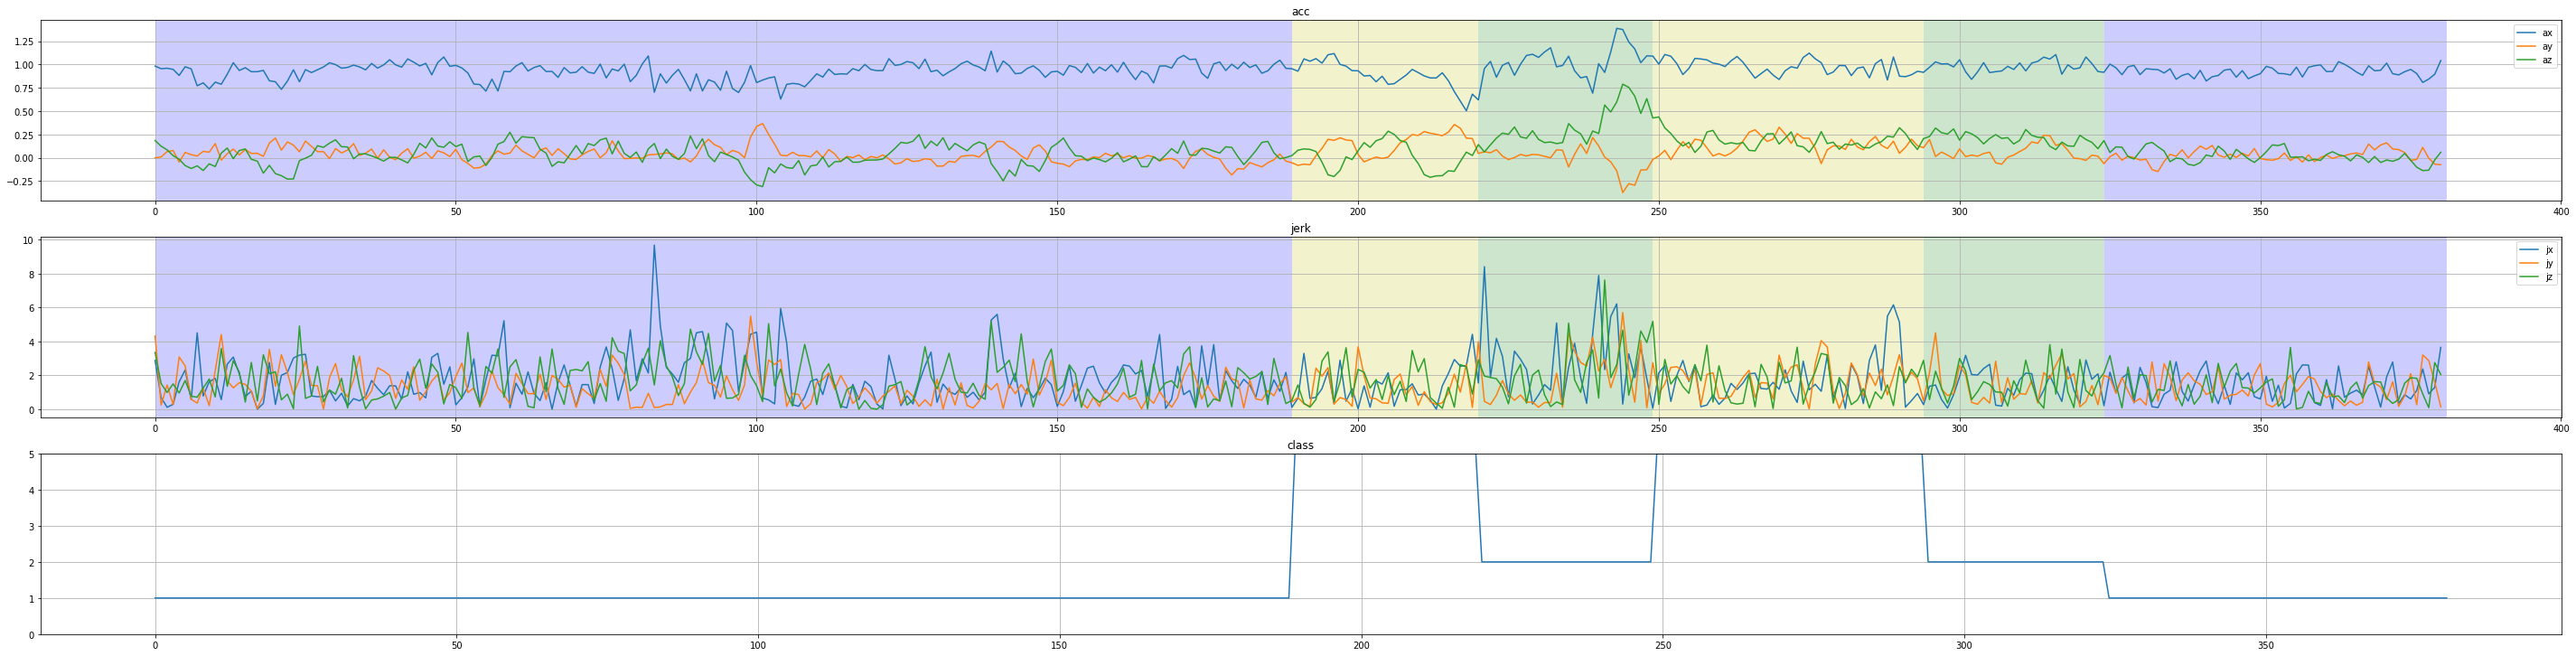

In [86]:
################################################################################
#                     READING A FILE AND PLOT (DEMO ONLY)                      #
################################################################################
demo_dataset1 = read_file(train_path, '76.CSV', n_class)
plot_data(demo_dataset1)

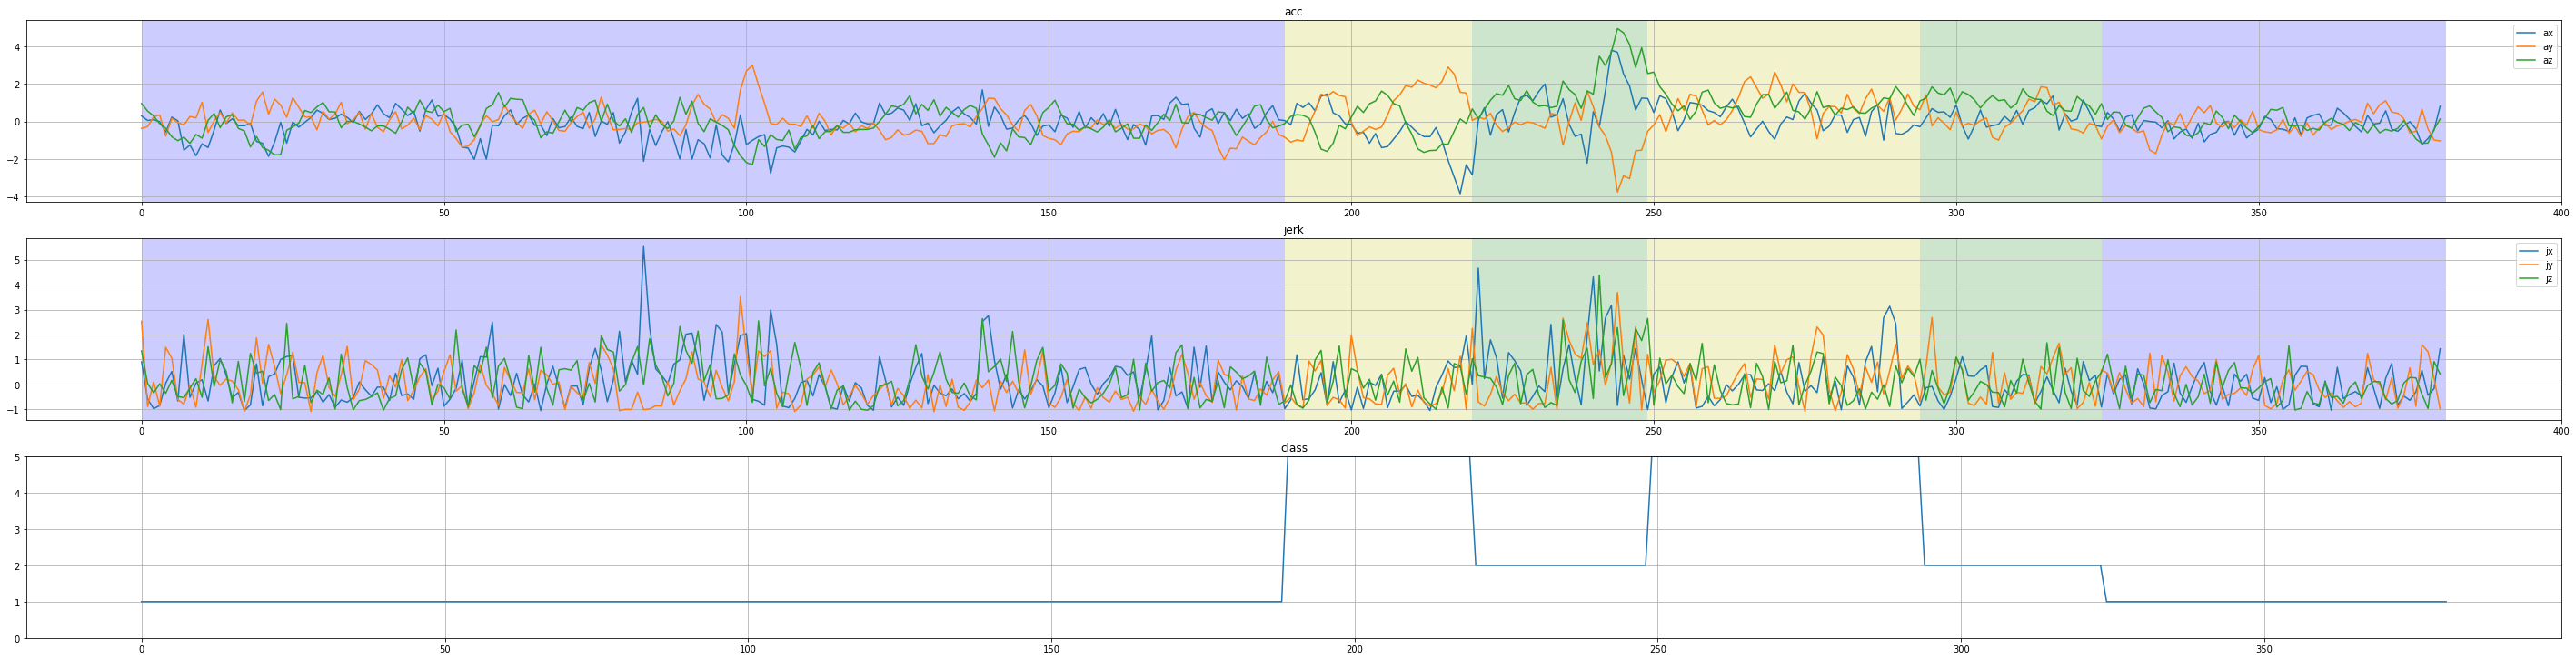

In [87]:
normalize([demo_dataset1], means, stds)
plot_data(demo_dataset1)

In [48]:
################################################################################
#                     NORMALIZING THE TRAINING DATASETS                        #
################################################################################
normalize(train_idle_aug, means, stds)
normalize(train_cruise_aug, means, stds)
normalize(train_acc_aug, means, stds)
normalize(train_brake_aug, means, stds)
normalize(train_left_aug, means, stds)
normalize(train_right_aug, means, stds)

In [49]:
################################################################################
#                      NORMALIZING THE VALIDATION DATASETS                     #
################################################################################
normalize(valid_idle_aug, means, stds)
normalize(valid_cruise_aug, means, stds)
normalize(valid_acc_aug, means, stds)
normalize(valid_brake_aug, means, stds)
normalize(valid_left_aug, means, stds)
normalize(valid_right_aug, means, stds)

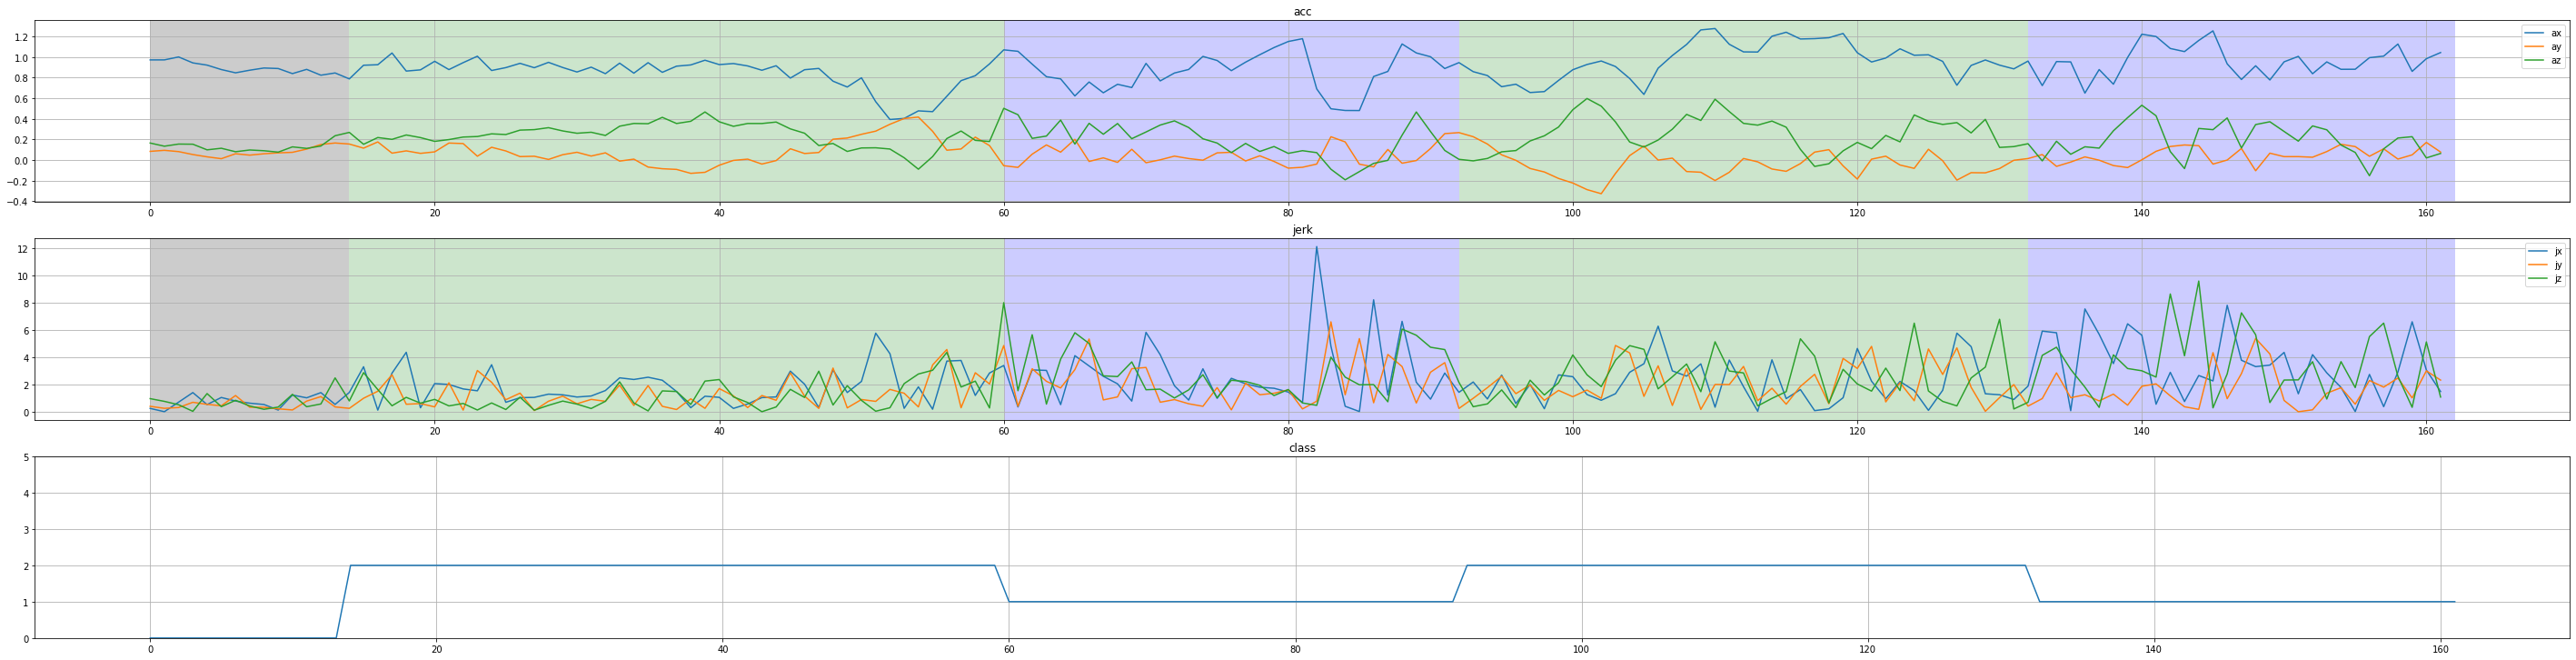

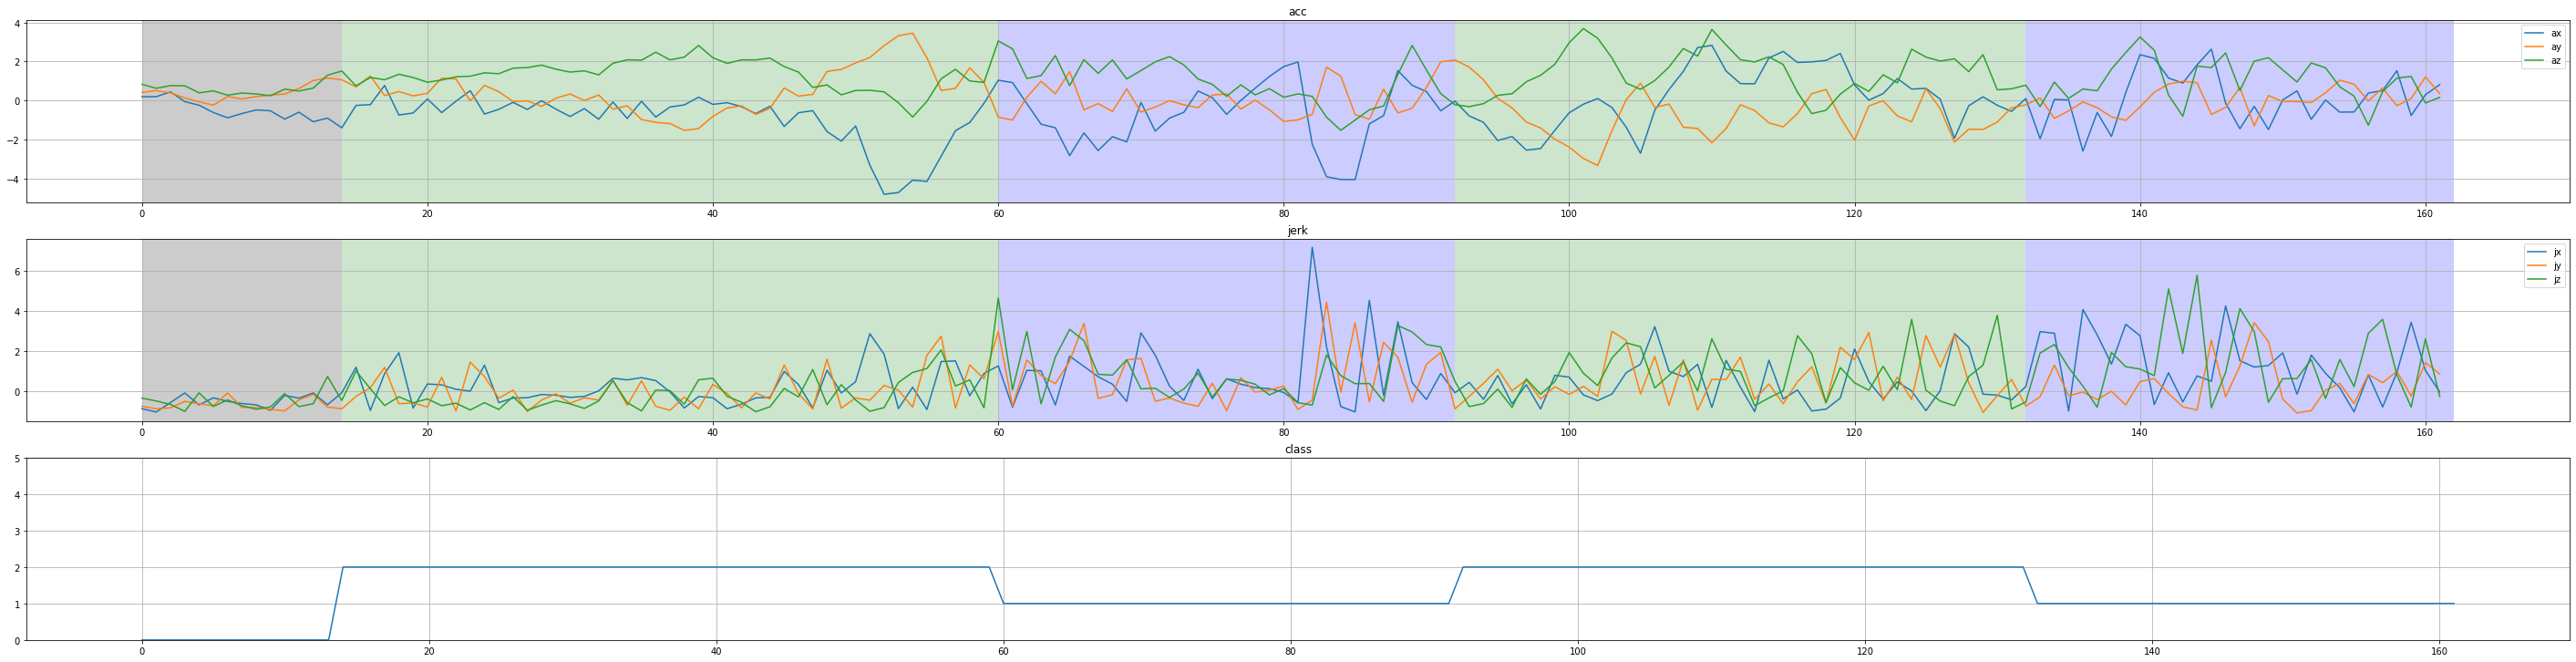

In [50]:
################################################################################
#              SHOWING THE RESULT OF NORMALIZATION BY DEMO DATASET             #
################################################################################
plot_data(demo_dataset1)
normalize([demo_dataset1], means, stds)
plot_data(demo_dataset1)

## g. Split data sequences 

In [51]:
def split_dataset(dataset, n_steps, motion_class):
  '''
  This function split input dataset into three outputs:
  x: an array with shape(len(dataset) - n_steps + 1, n_steps, 6), 
  containing the information in a time interval has duration equals to n_steps.
  y1: the classification of motion of x.
  y2: the information next to the last time information of x.
  '''
  x, y1, y2 = list(), list(), list()
  # x: states of vehicle has duration is equal to n_steps 
  # y1: category of the motion
  # y2: next state of the vehicle  
  for i in range(len(dataset)):
    end_ix = i + n_steps
    # check if index is output of bound
    if end_ix > len(dataset)-1:
      break
    m1 = np.argmax(dataset[i][6:])
    m2 = np.argmax(dataset[end_ix - 1][6:])
    # Check the class of input class and read class is compatiple,
    # the input dataset should be of same class
    if m1 != motion_class or m2 != motion_class:
      print("Uncompatible class: Expect", motion_class, 'but get',m1,'/',m2)
      continue
    seq_x, seq_y1, seq_y2 = dataset[i:end_ix, :6], dataset[end_ix-1, 6:], dataset[end_ix, :3]
    x.append(seq_x)
    y1.append(seq_y1)
    y2.append(seq_y2)
  
  return array(x), array(y1), array(y2)

In [52]:
def generate_seq(list_of_datasets, n_steps, motion_class):
  '''
  This is an higher level function,   which splits all datasets in 
  list_of_datasets into sequences.
  '''
  x, y1, y2 = np.empty(shape=(0,n_steps,6)), np.empty(shape=(0,6)), np.empty(shape=(0,3))
  for i in range(len(list_of_datasets)):
    # Check if the dataset is longer than n_steps
    if list_of_datasets[i].shape[0] <= n_steps:
      #print('skip')
      continue
    tx, ty1, ty2 = split_dataset(list_of_datasets[i], n_steps, motion_class)
    #print('i:',i,'/',tx.shape, ty1.shape, ty2.shape)
    x = np.append(x, tx, axis=0)
    y1 = np.append(y1, ty1, axis=0)
    y2 = np.append(y2, ty2, axis=0)
  
  return array(x), array(y1), array(y2)

In [53]:
################################################################################
#                         SPLITTING TRAINING SEQUENCES                         #
################################################################################
x_train_idle, y1_train_idle, y2_train_idle = generate_seq(train_idle_aug, n_steps, 0)
x_train_cruise, y1_train_cruise, y2_train_cruise = generate_seq(train_cruise_aug, n_steps, 1)
x_train_acc, y1_train_acc, y2_train_acc = generate_seq(train_acc_aug, n_steps, 2)
x_train_brake, y1_train_brake, y2_train_brake = generate_seq(train_brake_aug, n_steps, 3)
x_train_left, y1_train_left, y2_train_left = generate_seq(train_left_aug, n_steps, 4)
x_train_right, y1_train_right, y2_train_right = generate_seq(train_right_aug, n_steps, 5)

In [54]:
################################################################################
#                      SPLITTING VALIDATION SEQUENCES                          #
################################################################################
x_valid_idle, y1_valid_idle, y2_valid_idle = generate_seq(valid_idle_aug, n_steps, 0)
x_valid_cruise, y1_valid_cruise, y2_valid_cruise = generate_seq(valid_cruise_aug, n_steps, 1)
x_valid_acc, y1_valid_acc, y2_valid_acc = generate_seq(valid_acc_aug, n_steps, 2)
x_valid_brake, y1_valid_brake, y2_valid_brake = generate_seq(valid_brake_aug, n_steps, 3)
x_valid_left, y1_valid_left, y2_valid_left = generate_seq(valid_left_aug, n_steps, 4)
x_valid_right, y1_valid_right, y2_valid_right = generate_seq(valid_right_aug, n_steps, 5)

In [58]:
################################################################################
#                        SHOWING THE SIZE OF EACH CLASS                        #
################################################################################
print('----------TRAINING----------')
print('x_train_idle  :', x_train_idle.shape)
print('x_train_cruise:', x_train_cruise.shape)
print('x_train_acc   :', x_train_acc.shape)
print('x_train_brake :', x_train_brake.shape)
print('x_train_left  :', x_train_left.shape)
print('x_train_right :', x_train_right.shape)
print('---------VALIDATION---------')
print('x_valid_idle  :', x_valid_idle.shape)
print('x_valid_cruise:', x_valid_cruise.shape)
print('x_valid_acc   :', x_valid_acc.shape)
print('x_valid_brake :', x_valid_brake.shape)
print('x_valid_left  :', x_valid_left.shape)
print('x_valid_right :', x_valid_right.shape)

----------TRAINING----------
x_train_idle  : (6397, 20, 6)
x_train_cruise: (16165, 20, 6)
x_train_acc   : (8371, 20, 6)
x_train_brake : (7111, 20, 6)
x_train_left  : (3525, 20, 6)
x_train_right : (3126, 20, 6)
---------VALIDATION---------
x_valid_idle  : (2672, 20, 6)
x_valid_cruise: (7100, 20, 6)
x_valid_acc   : (3225, 20, 6)
x_valid_brake : (3668, 20, 6)
x_valid_left  : (542, 20, 6)
x_valid_right : (950, 20, 6)


## h. Concatenate and shuffle sequences

In [59]:
################################################################################
#                      CONCATENATING TRAINING SEQUENCES                        #
################################################################################
x_train = np.concatenate((x_train_idle, x_train_cruise, x_train_acc, x_train_brake, x_train_left, x_train_right))
y1_train = np.concatenate((y1_train_idle, y1_train_cruise, y1_train_acc, y1_train_brake, y1_train_left, y1_train_right))
y2_train = np.concatenate((y2_train_idle, y2_train_cruise, y2_train_acc, y2_train_brake, y2_train_left, y2_train_right))

In [60]:
################################################################################
#                     CONCATENATING VALIDATION SEQUENCES                       #
################################################################################
x_valid = np.concatenate((x_valid_idle, x_valid_cruise, x_valid_acc, x_valid_brake, x_valid_left, x_valid_right))
y1_valid = np.concatenate((y1_valid_idle, y1_valid_cruise, y1_valid_acc, y1_valid_brake, y1_valid_left, y1_valid_right))
y2_valid = np.concatenate((y2_valid_idle, y2_valid_cruise, y2_valid_acc, y2_valid_brake, y2_valid_left, y2_valid_right))

In [65]:
################################################################################
#               SHOWING THE SIZE OF TRAINING AND VALIDATION DATA               #
################################################################################
print('----TRAINING----')
print('x_train :', x_train.shape)
print('y1_train:', y1_train.shape)
print('y2_train:', y2_train.shape)
print('---VALIDATION---')
print('x_valid :', x_valid.shape)
print('y1_valid:', y1_valid.shape)
print('y2_valid:', y2_valid.shape)

----TRAINING----
x_train : (44695, 20, 6, 1)
y1_train: (44695, 6)
y2_train: (44695, 3)
---VALIDATION---
x_valid : (18157, 20, 6, 1)
y1_valid: (18157, 6)
y2_valid: (18157, 3)


In [62]:
################################################################################
#                 SHUFFLLING TRAINING AND VALIDATION SEQUENCES                 #
################################################################################
x_train, y1_train, y2_train = shuffle(x_train, y1_train, y2_train, random_state=0)
x_valid, y1_valid, y2_valid = shuffle(x_valid, y1_valid, y2_valid, random_state=0)

In [64]:
################################################################################
#                        FITTING THE INPUT SHAPE OF CNN                        #
################################################################################
if len(x_train.shape ) < 4 and len(x_valid.shape) < 4:
  x_train = np.expand_dims(x_train, axis=-1)
  x_valid = np.expand_dims(x_valid, axis=-1)
print('x_train:', x_train.shape)
print('x_valid:', x_valid.shape)

x_train: (44695, 20, 6, 1)
x_valid: (18157, 20, 6, 1)


# Step 4: Build CNN model

## 1. Input layer

In [88]:
inputs = keras.Input(shape=(n_steps,6,1), name='inputs')

## 2. Classifier model

In [117]:
c = layers.Conv2D(filters=36,kernel_size=(3,3),padding='same',
                  activation='relu',input_shape=(n_steps,6,1))(inputs)
c = layers.MaxPool2D((3, 3),padding='same')(c)
c = layers.Conv2D(filters=16,kernel_size=(1,3),padding='same',activation='relu')(c)
c = layers.MaxPool2D((1,1), padding='same')(c)
c = layers.Flatten()(c)
c = layers.Dense(64,activation='relu')(c)
c = layers.Dense(128,activation='relu')(c)
c = layers.Dense(32,activation='relu')(c)
outputs_1 = layers.Dense(n_class,activation='relu')(c)
classifier = keras.Model(inputs=inputs,outputs=outputs_1,name='classifier_model')

quantize_model = tfmot.quantization.keras.quantize_model
classifier = quantize_model(classifier)
classifier.summary()

Model: "classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 6, 1)]        0         
_________________________________________________________________
quantize_layer_6 (QuantizeLa (None, 20, 6, 1)          3         
_________________________________________________________________
quant_conv2d_14 (QuantizeWra (None, 20, 6, 36)         435       
_________________________________________________________________
quant_max_pooling2d_14 (Quan (None, 7, 2, 36)          1         
_________________________________________________________________
quant_conv2d_15 (QuantizeWra (None, 7, 2, 16)          1779      
_________________________________________________________________
quant_max_pooling2d_15 (Quan (None, 7, 2, 16)          1         
_________________________________________________________________
quant_flatten_7 (QuantizeWra (None, 224)          

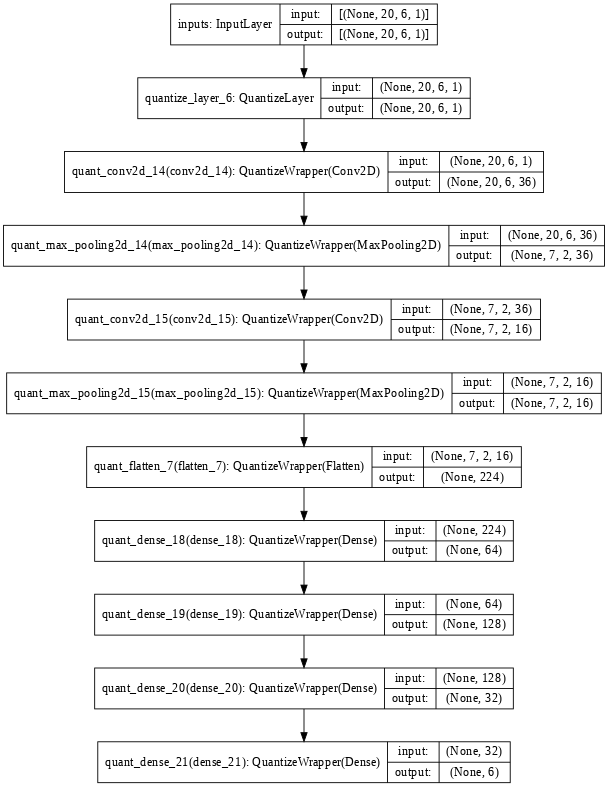

In [118]:
keras.utils.plot_model(classifier, "Classifier.png", show_shapes=True, dpi=64)

## Predictor model

In [123]:
p = layers.Conv2D(filters=36,kernel_size=(3,3),padding='same',activation='linear',input_shape=(n_steps,6,1))(inputs)
p = layers.MaxPool2D((3, 3),padding='same')(p)
p = layers.Conv2D(filters=16,kernel_size=(1,3),padding='same',activation='linear')(p)
p = layers.MaxPool2D((1,1), padding='same')(p)
p = layers.Flatten()(p)
p = layers.Dense(64,activation='linear')(p)
p = layers.Dense(32,activation='linear')(p)
outputs_2 = layers.Dense(3,activation='linear')(p)
predictor = keras.Model(inputs=inputs,outputs=outputs_2,name='predictor_model')

quantize_model = tfmot.quantization.keras.quantize_model
predictor = quantize_model(predictor)
predictor.summary()

Model: "predictor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 6, 1)]        0         
_________________________________________________________________
quantize_layer_8 (QuantizeLa (None, 20, 6, 1)          3         
_________________________________________________________________
quant_conv2d_18 (QuantizeWra (None, 20, 6, 36)         435       
_________________________________________________________________
quant_max_pooling2d_18 (Quan (None, 7, 2, 36)          1         
_________________________________________________________________
quant_conv2d_19 (QuantizeWra (None, 7, 2, 16)          1779      
_________________________________________________________________
quant_max_pooling2d_19 (Quan (None, 7, 2, 16)          1         
_________________________________________________________________
quant_flatten_9 (QuantizeWra (None, 224)           

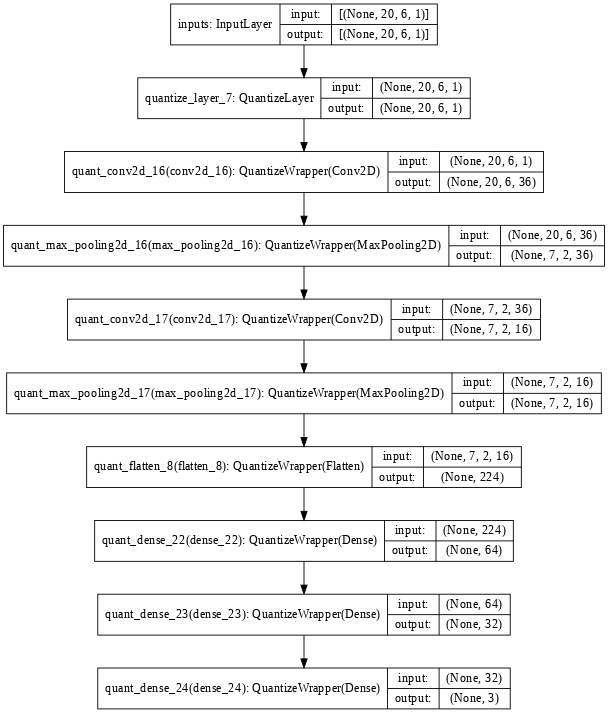

In [120]:
keras.utils.plot_model(predictor, "Predictor.png", show_shapes=True, dpi=64)

## Train the classifier model

In [95]:
classifier_path = '/content/drive/My Drive/Colab Notebooks/KerasModels/Classifier/classifier.h5'
check_pt_c = keras.callbacks.ModelCheckpoint(classifier_path, monitor='val_loss', verbose=0, save_best_only=True)

In [127]:
classifier.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

In [128]:
classifier_history = classifier.fit(
                    x_train, 
                    y1_train,                    
                    epochs=50, 
                    batch_size = 10000,
                    validation_data = (x_valid ,y1_valid),
                    verbose=1,
                    callbacks=check_pt_c
                    )

Epoch 1/50
5/5 [==============================] - 8s 1s/step - loss: 10.0246 - accuracy: 0.0745 - val_loss: 9.9900 - val_accuracy: 0.1311
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 10.5543 - accuracy: 0.1518 - val_loss: 9.9822 - val_accuracy: 0.1717
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 10.6776 - accuracy: 0.1835 - val_loss: 10.3437 - val_accuracy: 0.1771
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 10.7225 - accuracy: 0.1869 - val_loss: 10.3398 - val_accuracy: 0.1776
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 10.8148 - accuracy: 0.1873 - val_loss: 10.2872 - val_accuracy: 0.1776
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 10.7304 - accuracy: 0.1873 - val_loss: 10.3274 - val_accuracy: 0.1776
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 10.5517 - accuracy: 0.1873 - val_loss: 10.3318 - val_accuracy: 0.1776
Epoch 8/50
5/5 [=============

## Train the predictor model

In [97]:
predictor_path = '/content/drive/My Drive/Colab Notebooks/KerasModels/Predictor/predictor.h5'
check_pt_p = keras.callbacks.ModelCheckpoint(predictor_path, monitor='val_loss', verbose=0, save_best_only=True)

In [130]:
predictor.compile(optimizer='rmsprop',
              loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy'],
              )

In [132]:
predictor_history = predictor.fit(
                    x_train, 
                    y2_train,                    
                    epochs=50, 
                    batch_size = 10000,
                    validation_data = (x_valid ,y2_valid),
                    verbose=1,
                    callbacks=check_pt_p
                    )

Epoch 1/50
5/5 [==============================] - 5s 1s/step - loss: 1.0367 - accuracy: 0.3712 - val_loss: 1.0972 - val_accuracy: 0.4233
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 0.9002 - accuracy: 0.4366 - val_loss: 1.0352 - val_accuracy: 0.4496
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 0.8485 - accuracy: 0.4628 - val_loss: 0.9790 - val_accuracy: 0.4658
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.8724 - accuracy: 0.4510 - val_loss: 0.9553 - val_accuracy: 0.4816
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.7799 - accuracy: 0.4990 - val_loss: 0.9080 - val_accuracy: 0.5094
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.7693 - accuracy: 0.5024 - val_loss: 0.8759 - val_accuracy: 0.5130
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.7315 - accuracy: 0.5221 - val_loss: 0.8571 - val_accuracy: 0.5210
Epoch 8/50
5/5 [=========================

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f4f7e086a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


## Merging two models

In [133]:
common_input = classifier.input
out_1 = classifier(common_input)
out_2 = predictor(common_input)
merge_out = layers.concatenate([out_1,out_2])

final_model = keras.Model(inputs=common_input,outputs=merge_out,name='PNN')
final_model.summary()

Model: "PNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 20, 6, 1)]   0                                            
__________________________________________________________________________________________________
classifier_model (Functional)   (None, 6)            29286       inputs[0][0]                     
__________________________________________________________________________________________________
predictor_model (Functional)    (None, 3)            18814       inputs[0][0]                     
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 9)            0           classifier_model[2][0]           
                                                                 predictor_model[1][0]          

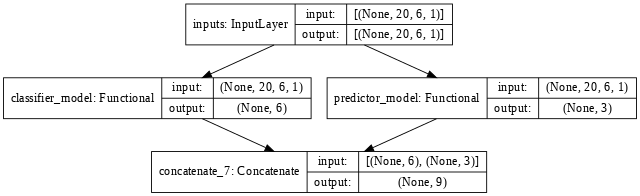

In [134]:
keras.utils.plot_model(final_model, "PNN.png", show_shapes=True, dpi=64)

## Simple testing

In [137]:
final_pred = final_model.predict(x_valid[0:1])
classifier_pred = classifier.predict(x_valid[0:1])
predictor_pred = predictor.predict(x_valid[0:1])
print(classifier_pred)
print(predictor_pred)
print(final_pred[0])

[[0.34655553 0.65460503 0.3850617  0.65460503 0.19253081 0.07701226]]
[[-0.26599878 -0.31033194 -1.0639956 ]]
[ 0.34655553  0.65460503  0.3850617   0.65460503  0.19253081  0.07701226
 -0.26599878 -0.31033194 -1.0639956 ]


## Save the final model

In [138]:
!pip install pyyaml h5py

In [139]:
model_name = 'PNN'
h5_path = 'KerasModels/Final/' + model_name + '.h5'
tf_path = 'KerasModels/Final/' + model_name + '.tf'

In [143]:
run_model = tf.function(lambda x: final_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = 6
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE, 1], final_model.inputs[0].dtype))
final_model.save(tf_path, signatures=concrete_func)

INFO:tensorflow:Assets written to: KerasModels/Final/PNN.tf/assets


INFO:tensorflow:Assets written to: KerasModels/Final/PNN.tf/assets


In [147]:
with tfmot.quantization.keras.quantize_scope():
  load_model = tf.keras.models.load_model(tf_path)
load_model.summary()

Model: "PNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 20, 6, 1)]   0                                            
__________________________________________________________________________________________________
classifier_model (Functional)   (None, 6)            29286       inputs[0][0]                     
__________________________________________________________________________________________________
predictor_model (Functional)    (None, 3)            18814       inputs[0][0]                     
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 9)            0           classifier_model[0][0]           
                                                                 predictor_model[0][0]          

In [148]:
model = load_model_h5

# Step 5: convert to tensorflow lite model

In [150]:
TFLite_path = 'TFLiteModels/' + model_name + '.tflite'

In [151]:
X_train_f32 = tf.cast(x_train, tf.float32)
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train_f32).batch(1).take(100):
    yield [input_value]

In [1]:
converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
TFLite_model = converter.convert()

NameError: ignored

In [ ]:
open(TFLite_path, "wb").write(TFLite_model)
print("TFLite models and their sizes:")
!ls "TFLiteModels" -lh

TFLite models and their sizes:
total 28K
-rw------- 1 root root 28K Jul 11 02:21 PNN.h5.tflite


# Step 6: Quantize tensorflow lite model

In [ ]:
TFLite_interpreter = tf.lite.Interpreter(model_path=TFLite_path)

input_details = TFLite_interpreter.get_input_details()
output_details = TFLite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_x:0
shape: [ 1 15  6  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:1
shape: [1 3]
type: <class 'numpy.int8'>


In [ ]:
TFLite_interpreter.resize_tensor_input(input_details[0]['index'], (1, n_steps, 6, 1))
TFLite_interpreter.resize_tensor_input(output_details[0]['index'], (1,n_class))
TFLite_interpreter.allocate_tensors()

input_details = TFLite_interpreter.get_input_details()
output_details = TFLite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
input_scale = input_details[0]['quantization'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
print(input_scale, input_zero_point)
output_scale = output_details[0]['quantization'][0]
output_zero_point = float(output_details[0]['quantization_parameters']['zero_points'][0])
print(output_scale, output_zero_point)

== Input details ==
name: serving_default_x:0
shape: [ 1 15  6  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:1
shape: [1 3]
type: <class 'numpy.int8'>
0.21337780356407166 -28
0.00390625 -128.0


In [ ]:
TFLite_interpreter.set_tensor(input_details[0]['index'], ([(((x_valid[0])/input_scale)+input_zero_point).astype('int8')]))
TFLite_interpreter.runForMultipleInputsOutputs(x_valid[0])
TFLite_model_predictions = TFLite_interpreter.get_tensor(output_details[0]['index'])
print(TFLite_model_predictions)

AttributeError: ignored